In [42]:
import torch
from torch import nn
from d2l import torch as d2l

## Generating Dataset

Generating a nonlinear dataset with a noise term:

$$
y_i = 2 \sin x_i + x_i^{0.8} + \varepsilon,
$$

where $\varepsilon \sim N(0, 0.5^2)$.

In [43]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

In [44]:
f = lambda x: 2 * torch.sin(x) + x ** 0.8

In [45]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

In [46]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y',
             legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)


## Nonparametric Attention Pooling

While estimate the label, we can weigh the outputs $y_i$ according to their input locations:

$$
f(x) = \sum_{i = 1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i
$$

$K$ is a function called **kernel**; we can consider a Gaussian kernel:

$$
K(u) = \frac{1}{\sqrt{2 \pi}} \exp{\left( -\frac{u^2}{2} \right)}
$$

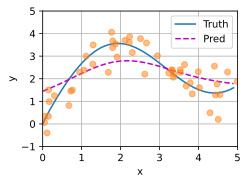

In [47]:
# repeat_interleave: Repeat the entries of the tensor for n times
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

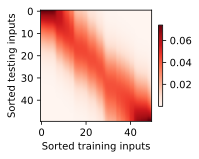

In [48]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')


## Parametric Attention Pooling 参数化注意力聚合

### Batch Matrix Multiplication

Use the first dimension to represent different matrix

使用第一个维度存储不同的矩阵

In [49]:
X = torch.ones((2, 1, 4)); Y = torch.ones((2, 4, 6))
Z = torch.bmm(X, Y)

In [50]:
print(X[0] @ Y[0])
print(Z[0])

tensor([[4., 4., 4., 4., 4., 4.]])
tensor([[4., 4., 4., 4., 4., 4.]])


In [51]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
# .unsqueeze: Add a dimension to the tensor
# e.g. 3 -> [3] -> [[3]], a scalar to a 1-dim vector, then to a 1x1 matrix.
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [57]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    # keys for nonvotional cues, and queries for votional cues
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)


In [54]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


In [55]:
keys

tensor([[0.0600, 0.1131, 0.1472,  ..., 4.5493, 4.7454, 4.9956],
        [0.0480, 0.1131, 0.1472,  ..., 4.5493, 4.7454, 4.9956],
        [0.0480, 0.0600, 0.1472,  ..., 4.5493, 4.7454, 4.9956],
        ...,
        [0.0480, 0.0600, 0.1131,  ..., 4.5046, 4.7454, 4.9956],
        [0.0480, 0.0600, 0.1131,  ..., 4.5046, 4.5493, 4.9956],
        [0.0480, 0.0600, 0.1131,  ..., 4.5046, 4.5493, 4.7454]])

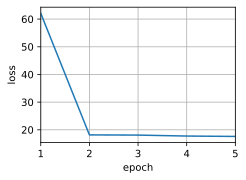

In [58]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))
